# Whatpulse Keypress Counter

By Kenneth Burchfiel

Released under the MIT license

This program reads Whatpulse keypress data (stored in local SQLite databases); combines that data into a single Pandas DataFrame; and then performs analyses on that data.

More documentation/explanation of the code will be provided in the future.

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
current_computer_nickname = 'ga15pyd' # Used for naming .csv files

database_paths_list = ['C:\\Users\\kburc\\AppData\\Local\\whatpulse\\whatpulse.db', 'C:\\Users\\kburc\\D1V1\\Documents\\whatpulse_database_backups\\a13r2_whatpulse.db'] # Necessary to escape the backslashes

In [3]:
def analyze_keypresses(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True)    
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [4]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(analyze_keypresses(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 11591064
Maximum keypresses in one day with this computer: 73788
Average daily keypresses (at least for days with 1 or more keypresses): 24557.338983050846

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
742


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-11-07,35930
2022-11-08,36791
2022-11-09,53965


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses).

In [5]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'

In [6]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['30_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(30).mean()
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses['keypresses'].rank(pct=True)
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses['keypresses'].rank(ascending = False)
df_combined_daily_keypresses

782


,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
Date,,,,,,
2020-09-21,19081,NaN,NaN,NaN,38.874680,479.0
2020-09-22,32771,NaN,NaN,NaN,65.473146,271.0
2020-09-23,32065,NaN,NaN,NaN,64.066496,282.0
2020-09-24,34698,NaN,NaN,NaN,67.966752,251.5
2020-09-25,47038,NaN,NaN,NaN,86.572890,106.0
...,...,...,...,...,...,...
2022-11-07,35930,27395.428571,24665.800000,20535.597260,70.588235,231.0
2022-11-08,36791,27217.714286,25640.266667,20486.873973,72.250639,218.0
2022-11-09,53965,31403.428571,26532.566667,20432.564384,92.455243,60.0


<AxesSubplot:xlabel='Date'>

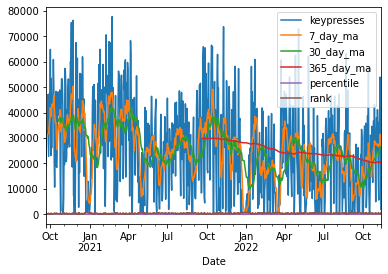

In [7]:
df_combined_daily_keypresses.plot()

Summary daily keypress data statistics:

In [8]:
df_combined_daily_keypresses['keypresses'].describe()

count      782.000000
mean     25684.167519
std      18104.441018
min          0.000000
25%       9844.500000
50%      25090.500000
75%      38680.750000
max      77753.000000
Name: keypresses, dtype: float64

In [9]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
Date,,,,,,
2022-11-02,24665,27339.714286,24267.500000,20556.068493,49.104859,399.0
2022-11-03,41168,27044.714286,24482.133333,20561.169863,78.772379,167.0
2022-11-04,32066,27613.285714,24475.933333,20541.627397,64.194373,281.0
2022-11-05,14284,26662.571429,24562.600000,20507.758904,30.818414,542.0
2022-11-06,5620,26758.000000,23555.600000,20443.230137,17.774936,644.0
2022-11-07,35930,27395.428571,24665.800000,20535.597260,70.588235,231.0
2022-11-08,36791,27217.714286,25640.266667,20486.873973,72.250639,218.0
2022-11-09,53965,31403.428571,26532.566667,20432.564384,92.455243,60.0
2022-11-10,41626,31468.857143,26625.033333,20443.989041,79.667519,160.0


The following cell calculates my top 50 one-day keypress totals.

In [10]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index()
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
0,1,2021-02-22,77753,47983.000000,41921.733333,NaN,100.000000,1.0
1,2,2020-11-23,76313,50377.571429,38630.666667,NaN,99.872123,2.0
2,3,2020-11-19,75444,47285.571429,38100.900000,NaN,99.744246,3.0
3,4,2021-11-09,73788,37843.285714,32561.166667,29584.802740,99.616368,4.0
4,5,2022-05-03,72910,30511.428571,29429.400000,24401.624658,99.488491,5.0
5,6,2021-02-08,70591,30177.428571,34684.800000,NaN,99.360614,6.0
6,7,2021-04-06,68313,40455.857143,41385.233333,NaN,99.232737,7.0
7,8,2021-02-15,67930,46174.571429,38828.533333,NaN,99.104859,8.0
8,9,2020-11-30,67533,20747.428571,35387.133333,NaN,98.976982,9.0
9,10,2021-02-17,67505,45946.571429,40793.766667,NaN,98.849105,10.0


<BarContainer object of 50 artists>

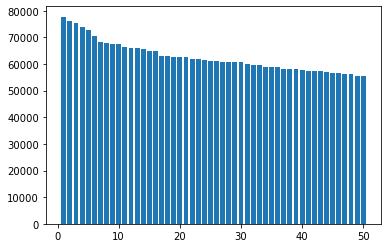

In [11]:
plt.bar(x = df_max_keypresses.head(50)['Rank'], height= df_max_keypresses.head(50)['keypresses'])

In [12]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
count,782.000000,776.000000,753.000000,418.000000,782.000000,782.000000
mean,25684.167519,25650.506443,25434.234529,25204.172819,50.063939,391.500000
std,18104.441018,10569.220463,7738.900907,2944.836617,28.883727,225.870748
min,0.000000,0.000000,10032.533333,20288.953425,2.749361,1.000000
25%,9844.500000,18195.857143,20022.666667,23123.643836,25.095908,196.250000
50%,25090.500000,26317.285714,24562.600000,24171.778082,50.063939,391.500000
75%,38680.750000,33182.714286,31481.966667,28087.698630,75.031969,586.750000
max,77753.000000,50377.571429,41971.566667,30033.476712,100.000000,761.500000


In [13]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      782.000000
mean     25684.167519
std      18104.441018
min          0.000000
50%      25090.500000
90%      50100.800000
91%      51540.430000
92%      53231.080000
93%      54597.970000
94%      56327.380000
95%      57887.800000
96%      59679.720000
97%      61335.090000
98%      63804.120000
99%      67608.430000
100%     77753.000000
max      77753.000000
Name: keypresses, dtype: float64

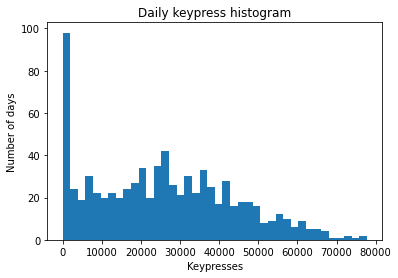

In [14]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 40)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [15]:
print("Total keypresess since", str(df_combined_daily_keypresses.index[0])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 20,085,019


In [16]:
df_combined_daily_keypresses.tail(50) # Last 50 days

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
Date,,,,,,
2022-09-23,12256,7276.714286,12669.200000,21637.904110,27.877238,565.0
2022-09-24,10698,8549.000000,11540.633333,21628.134247,26.342711,577.0
2022-09-25,23495,11905.428571,10695.166667,21674.764384,46.803069,417.0
2022-09-26,20895,11148.000000,11102.466667,21719.693151,41.943734,455.0
2022-09-27,33433,15046.142857,12216.900000,21631.936986,65.856777,268.0
2022-09-28,29908,18806.000000,12451.566667,21618.230137,60.230179,312.0
2022-09-29,163,18692.571429,11390.266667,21466.698630,6.777494,730.0
2022-09-30,0,16941.714286,11018.866667,21341.410959,2.749361,761.5
2022-10-01,0,15413.428571,10242.500000,21219.468493,2.749361,761.5


# (See above for recent keypress stats)

In [17]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Today's percentile: {percentile_today}")
print(f"Today's rank: {rank_today} (in front of {days_with_data - rank_today} days)")
print("Days ranked just ahead of today:")
df_combined_daily_keypresses.sort_values('rank').query("rank < @rank_today").tail(10)

Ranks are out of 782 days.
Today's keypresses: 1896.0
Today's percentile: 12.404092071611252
Today's rank: 686.0 (in front of 96.0 days)
Days ranked just ahead of today:


,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
Date,,,,,,
2021-11-20,2588,25767.428571,28355.366667,29117.452055,13.682864,676.0
2021-01-01,2574,4266.142857,25383.866667,NaN,13.554987,677.0
2021-05-02,2520,6969.000000,25743.666667,NaN,13.427110,678.0
2022-01-28,2382,26262.857143,22673.033333,27574.884932,13.299233,679.0
2021-11-26,2348,13742.142857,24878.300000,28972.660274,13.171355,680.0
2021-06-12,2311,11408.000000,22835.233333,NaN,13.043478,681.0
2021-11-07,2216,20044.000000,30467.600000,29407.750685,12.915601,682.0
2020-12-30,2134,5149.714286,27458.766667,NaN,12.787724,683.0
2021-06-13,2081,11550.428571,21945.700000,NaN,12.659847,684.0


Looking for days with identical keypress totals:

In [18]:
df_combined_daily_keypresses[df_combined_daily_keypresses.duplicated(subset = 'keypresses', keep = False)].query('keypresses > 0').sort_values('keypresses', ascending = False)

,keypresses,7_day_ma,30_day_ma,365_day_ma,percentile,rank
Date,,,,,,
2020-10-23,48908,41125.571429,38187.633333,NaN,88.810742,88.5
2021-03-23,48908,36708.000000,33692.600000,NaN,88.810742,88.5
2020-09-24,34698,NaN,NaN,NaN,67.966752,251.5
2021-01-23,34698,34726.428571,22757.633333,NaN,67.966752,251.5
2021-08-05,32184,29066.857143,29680.833333,NaN,64.641944,277.5
2022-07-29,32184,26384.571429,26135.100000,23180.561644,64.641944,277.5
2022-08-09,26905,21784.571429,26186.500000,22972.580822,54.667519,355.5
2022-10-26,26905,25745.714286,21363.566667,20359.476712,54.667519,355.5
2020-11-15,26550,36325.285714,35217.600000,NaN,53.644501,363.5


In [19]:
# Total keypresses during MBA:

sum(df_combined_daily_keypresses.query(
    "Date >= '2020-08-20' & Date <= '2022-05-04'")['keypresses'])

16377578

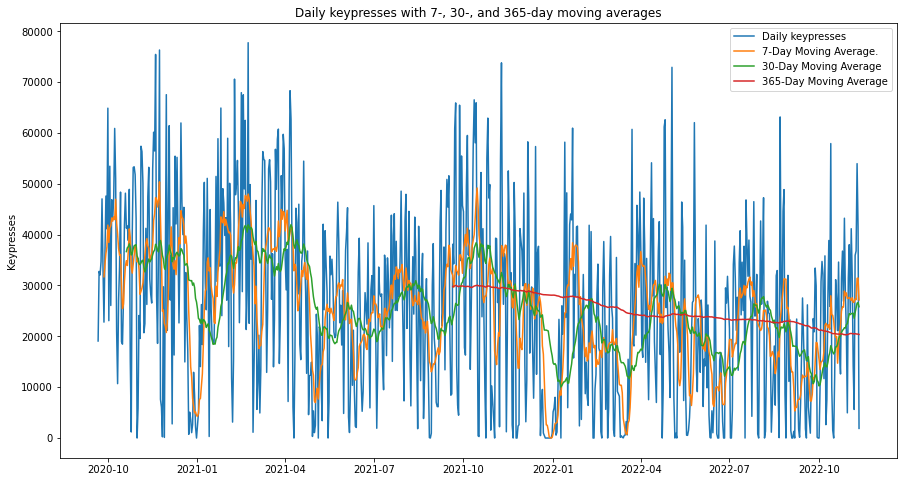

In [20]:
fig, axes = plt.subplots(figsize=[15,8])
fig.set_facecolor('white')

axes.plot(df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
axes.plot(df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average.')
axes.plot(df_combined_daily_keypresses['30_day_ma'],label='30-Day Moving Average')
axes.plot(df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend()
plt.title('Daily keypresses with 7-, 30-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

In [21]:
test_df = df_combined_daily_keypresses.copy()

In [22]:
df_monthly_keypresses = test_df.resample('M').sum()['keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['keypresses'] = df_monthly_keypresses.pop('keypresses')
df_monthly_keypresses

,Month,Year,keypresses
0,2020-09,2020,346918
1,2020-10,2020,1140421
2,2020-11,2020,1061614
3,2020-12,2020,823763
4,2021-01,2021,980116
5,2021-02,2021,1088404
6,2021-03,2021,1142850
7,2021-04,2021,833464
8,2021-05,2021,700155
9,2021-06,2021,621894


The following code shows my monthly keypresses from October to April during my 2-year MBA program.

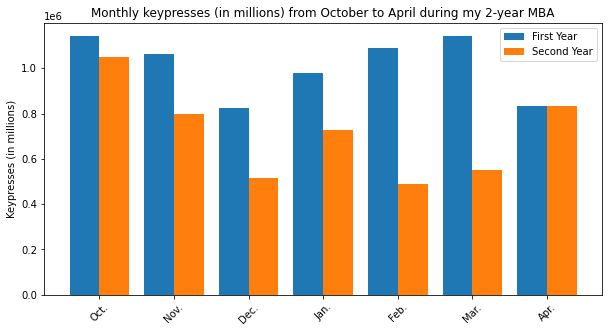

In [23]:
fig, axes = plt.subplots(figsize=[10, 5])
fig.set_facecolor('white')
# Much of the following code was based on:
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
df_first_year = df_monthly_keypresses.query("Month >= '2020-10' & Month <= '2021-04'").copy()
df_second_year = df_monthly_keypresses.query("Month >= '2021-10' & Month <= '2022-04'").copy()
width = 0.4
x = np.arange(len(df_first_year))
axes.bar(x = x - width/2, height = df_first_year['keypresses'], label = 'First Year', width = width)
axes.bar(x = x + width/2, height = df_second_year['keypresses'], label = 'Second Year', width = width)
axes.set_xticks(x, ['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.'], rotation = 45)
plt.legend()
plt.ylabel('Keypresses (in millions)')
plt.title('Monthly keypresses (in millions) from October to April during my 2-year MBA')
plt.savefig('graphs\\monthly_keypresses_during_MBA.png', dpi=400)

List of tables in each WhatPulse database file:

In [24]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [25]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

In [26]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Fri Nov 11 00:25:06 2022 (local time)
Total run time: 5.63 second(s) (0.0 minute(s) and 5.63 second(s))
